# Importing and preprocessing of data

In [1]:
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
TXTS_PATH = '/content/drive/My Drive/Becode/Kpmg/selection_fr'

In [3]:
import os

In [4]:
import pandas as pd

In [5]:
RESPONSES_PATH = '/content/drive/My Drive/Becode/Kpmg/responses_2018_now.json'

In [6]:
txt_filenames = [f for f in os.listdir(TXTS_PATH) if f.endswith(".txt")]

In [7]:
#reading json file to retrieve tags
responses = pd.read_json(RESPONSES_PATH)

In [8]:
#filtering only relevant columns
columns = ['jcId', 'jcFr', 'titleFr', 'themesFr', 'scopeFr', 'noScopeFr', 'documentLink']
responses2 = responses.copy(deep=True).loc[:,columns]
#getting txt_name from original pdf name
responses2["txt_name"] = responses2["documentLink"]
responses2["txt_name"] = responses2["txt_name"].str.replace("/","-")
responses2["txt_name"] = responses2["txt_name"].str.replace(".pdf","_FR.txt")
#filtering json only for selected files and columns
columns += ['txt_name']
responses2 = responses2.loc[responses2.txt_name.isin(txt_filenames), columns]
responses2.head(2)

,jcId,jcFr,titleFr,themesFr,scopeFr,noScopeFr,documentLink,txt_name
34,1110000,COMMISSION PARITAIRE DES CONSTRUCTIONS METALLI...,modification du régime de pension sectoriel so...,[PENSIONS COMPÉMENTAIRES ET ASSURANCES GROUPES],None,[les employeurs et ouvriers des entreprises ex...,111/111-2018-013525.pdf,111-111-2018-013525_FR.txt
35,1110000,COMMISSION PARITAIRE DES CONSTRUCTIONS METALLI...,allocation spéciale compensatoire,[PRIME SYNDICALE],None,None,111/111-2018-012196.pdf,111-111-2018-012196_FR.txt


In [9]:
#generating all possible FR themes
themes_fr = []
for r in  responses2.themesFr:
    if r is not None:
        for t in r:
            if t not in themes_fr:
                themes_fr += [t]
len(themes_fr)


53

In [10]:
#code to retrieve the entire body
#%%
for filename in responses2.txt_name.to_list():
    # filename = responses2.txt_name.to_list()[10] #test
    file_path = os.path.join(TXTS_PATH, filename)
    with open(file_path, 'r', encoding="utf8") as f:
        #to retrieve entire body not necessary
        responses2.loc[responses2.txt_name == filename, "doc_bodies"] = f.read()
        f.close()

In [11]:
t = themes_fr[0]
mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)

In [12]:
len(responses2)

549

In [13]:
 #len(responses2.dropna(axis=0, subset=['themesFr'])[map])

# Preprocessing for NLP

In [ ]:
from pandas import Series

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

# import entirely spacy to create Doc objects through nlp
import spacy
from spacy import load, lang

from wordcloud import WordCloud

from collections import Counter

from typing import List
from typing import Dict

# WARNINGS
# W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
# I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine

# GLOBAL VARIABLES
NAMED_ENTITIES = ['microsoft']

#testing
from os import getcwd as cwd
from os.path import dirname as dir
from os.path import join
import pandas as pd

In [60]:
def lemmatize(text_tokens: List[str]) -> List[str]:
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    texts_lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in text_tokens]
    return texts_lemmatized


def filter_words(texts_lemmatized: List[List[str]], freq_min=None, freq_max=None):
    frequency_absolute = Counter([item for elem in texts_lemmatized for item in elem])
    wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(frequency_absolute)
    frequency_relative = wordcloud.words_
    if freq_min is not None and freq_min > 0 and freq_min < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v > freq_min}
    if freq_max is not None and freq_max > 0 and freq_max < 1:
        rel_freq_filtered = {k: v for k, v in frequency_relative.items() if v < freq_max}
    texts_filtered = [[t for t in pub_lem if t in rel_freq_filtered.keys()] for pub_lem in texts_lemmatized]
    # testing part
    f_abs_updated =Counter([ item for elem in texts_filtered for item in elem])   
    wordcloud_updated = WordCloud(width=1000, height=500).generate_from_frequencies(f_abs_updated)
    f_rel_updated = wordcloud_updated.words_
    return texts_filtered, f_abs_updated, f_rel_updated, wordcloud_updated


In [56]:
class Preprocess:
    def __init__(self, nlp_model='en_core_web_md'):
        self.nlp = load(nlp_model)
        if 'en_' in nlp_model:
          self.stop_words = lang.en.stop_words.STOP_WORDS
        elif 'fr_' in nlp_model:
          self.stop_words = lang.fr.stop_words.STOP_WORDS
        self.named_entities = set(NAMED_ENTITIES)

    def get_named_entities(self, texts: Series, inplace=True) -> set:
        # creating a single ner set
        nes = set()
        # function to extract NER from text
        def get_named_entities(text) -> set:
            doc = self.nlp(text)
            named_entities = set([ent.text for ent in doc.ents])
            return named_entities
        [[nes.add(n) for n in get_named_entities(text)] for text in texts]
        # adding predefined NER
        [nes.add(n) for n in self.named_entities]
        if inplace:
            self.named_entities = nes
        return nes

    def tokenize_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[str]:
        if stop_words is None:
            stop_words = self.stop_words
        if named_entities is None:
            named_entities = self.named_entities
        text = text.replace("\n", " ")
        # split string into words (tokens)
        tokens = word_tokenize(text.lower())
        # keep strings with only alphabets
        tokens = [t for t in tokens if t.isalpha()]
        tokens = lemmatize(tokens)
        # remove short words, they're probably not useful
        tokens = [t for t in tokens if len(t) > lenght_min]
        # remove stopwords
        tokens = [t for t in tokens if t not in stop_words]
        # remove
        tokens = [t for t in tokens if t not in named_entities]
        return tokens

    def clean_text(self, text:str, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> str:
        tokens = self.tokenize_text(text, stop_words, named_entities, lenght_min)
        text_cleaned = " ".join(tokens)
        return text_cleaned

    def tokenize_texts(self, texts:Series, stop_words: List[str] = None, named_entities: List[str] = None,
                   lenght_min: int=2) -> List[List[str]]:
        texts_tokens = []
        for text in texts:
            texts_tokens += [self.tokenize_text(text, stop_words, named_entities, lenght_min)]
        return texts_tokens

In [15]:
! python -m spacy download fr_core_news_md

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [16]:
import spacy
nlp = spacy.load('fr_core_news_md')

In [57]:
preprocess = Preprocess(nlp_model='fr_core_news_md')

In [52]:
# example of FR stopwords from the set
list(preprocess.stop_words)[:10]

['pire',
 'suivantes',
 'sa',
 'abord',
 'd’',
 'eh',
 'malgre',
 'pense',
 'pour',
 'elle-même']

In [34]:
# importing nltk and downloading additional required packages
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [35]:
#cleaning text before extracting word clouds
responses2["bodies_cleaned"] = responses2["doc_bodies"].apply(preprocess.clean_text)

# Labelling

In [58]:
#extracting all words with relative frequency > 0.5
all_ts = preprocess.tokenize_texts(responses2.bodies_cleaned)

In [61]:
texts, f_abs, f_rel, wordcloud = filter_words(all_ts, freq_min=0.5)

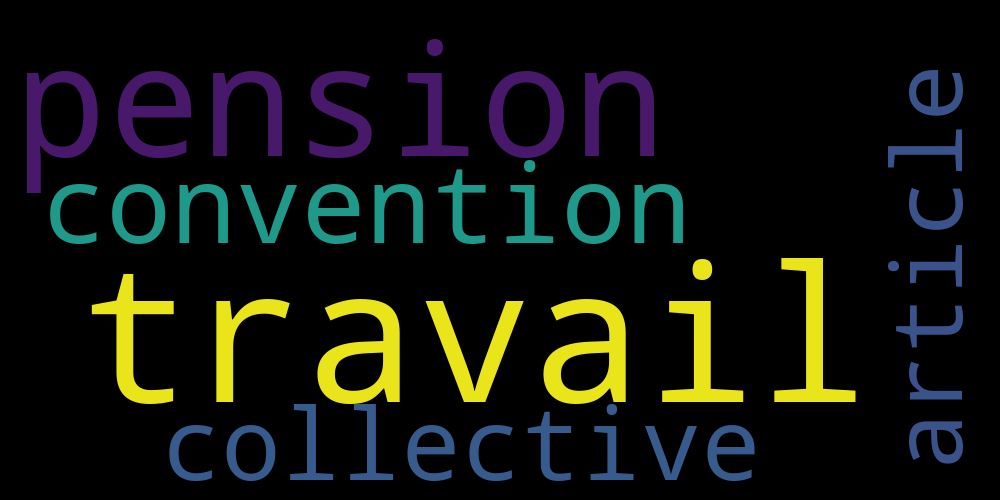

In [62]:
wordcloud.to_image()

In [74]:
# adding most frequent words as stop words
[preprocess.stop_words.add(w) for w in list(f_rel.keys())]
[w for w in list(preprocess.stop_words) if w in list(f_rel.keys())]

['travail', 'convention', 'collective', 'pension', 'article']

In [73]:
[w for w in list(preprocess.stop_words) if w in list(f_rel.keys())]

['travail', 'convention', 'collective', 'pension', 'article']

In [77]:
themes_keywords = pd.DataFrame(columns=['themeFr', 'frequency_absolute', 'frequency_relative'])
for t in themes_fr:
  mask = responses2.dropna(axis=0, subset=['themesFr']).themesFr.map(lambda x: t in x)
  r_t = responses2.dropna(axis=0, subset=['themesFr'])[mask]
  t_ts = preprocess.tokenize_texts(r_t["bodies_cleaned"])
  t_texts, t_f_abs, t_f_rel, t_wordcloud = filter_words(t_ts, freq_min=0.05, freq_max=0.95)
  themes_keywords = themes_keywords.append({'themeFr':t, 'frequency_absolute':t_f_abs, 'frequency_relative':t_f_rel}, ignore_index=True)
  print(f'Kewyords for {t} added')



In [78]:
themes_keywords.to_csv('/content/drive/My Drive/Becode/Kpmg/labeling.csv')

In [80]:
themes_keywords.frequency_relative

0     {'règlement': 1.0, 'régime': 0.929403701165181...
1     {'cotisation': 1.0, 'partir': 0.92733564013840...
2     {'ouvriers': 1.0, 'prime': 0.9321705426356589,...
3     {'mois': 1.0, 'art': 0.9333333333333333, 'juil...
4     {'salaires': 1.0, 'minimum': 0.929133858267716...
5     {'art': 1.0, 'prime': 0.9014084507042254, 'ent...
6     {'fonds': 1.0, 'van': 0.772189349112426, 'janv...
7     {'fin': 1.0, 'cct': 0.9087719298245615, 'prése...
8     {'ouvriers': 1.0, 'salaires': 0.92041078305519...
9     {'minimum': 1.0, 'salaires': 0.993392070484581...
10    {'travailleurs': 1.0, 'fonds': 0.9964788732394...
11    {'ouvriers': 1.0, 'mois': 0.7898832684824902, ...
12    {'fonds': 1.0, 'chômage': 0.7973333333333333, ...
13    {'travailleurs': 1.0, 'fonds': 0.9289215686274...
14    {'chômage': 1.0, 'van': 0.8837209302325582, 'r...
15    {'cotisation': 1.0, 'travailleurs': 0.91981132...
16    {'régime': 1.0, 'formation': 0.982425307557117...
17    {'partir': 1.0, 'travailleurs': 0.96793002